# Data Loading and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dython import nominal
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import pickle

In [2]:
data_dir = './data/'

In [3]:
results_dir = './data/results/'

In [4]:
models_dir = './models/'

In [5]:
model_name = 'logistic_classification'

In [6]:
classification_data = pd.read_csv(data_dir+'classification_data.csv', index_col=[0])

# Logistic Regression (Classification)

In [7]:
classification_data

,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,yes,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,1,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,yes,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,1,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,yes,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,1,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,yes,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,1,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,1,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,edible,knobbed,smooth,brown,no,none,attached,close,broad,yellow,enlarging,unknown,smooth,smooth,orange,1,pendant,buff,clustered,leaves
8120,edible,convex,smooth,brown,no,none,attached,close,broad,yellow,enlarging,unknown,smooth,smooth,brown,1,pendant,buff,several,leaves
8121,edible,flat,smooth,brown,no,none,attached,close,broad,brown,enlarging,unknown,smooth,smooth,orange,1,pendant,buff,clustered,leaves
8122,poisonous,knobbed,scaly,brown,no,fishy,free,close,narrow,buff,tapering,unknown,smooth,silky,white,1,evanescent,white,several,leaves


In [8]:
classification_data.shape

(8124, 20)

In [9]:
dep_var = 'edible'

In [10]:
X = classification_data.iloc[:,classification_data.columns != dep_var]

In [11]:
y = classification_data[dep_var]

In [12]:
y

0       poisonous
1          edible
2          edible
3       poisonous
4          edible
          ...    
8119       edible
8120       edible
8121       edible
8122    poisonous
8123       edible
Name: edible, Length: 8124, dtype: object

In [13]:
# Random 6-digit seed
test_seed = 513370

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=test_seed, stratify=y)

Initialise the dataframe that holds the results of the datasets

In [17]:
columns = ['task', 'model', 'seed', 'split', 'penalty', 'C', 'solver', 'train_accuracy', 'valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1_score', 'valid_auroc']
logistic_classification_results_df = pd.DataFrame(columns=columns)
df_rows = 0

In [18]:
# 5 random 6 digit numbers
seeds = [660108, 720389, 193768, 586930, 327407]

Now we need to prepare our data and the cross-validation process so that we can start training.

In [19]:
pd.options.mode.chained_assignment = None  # default='warn'
# Cross-Validation Pipeline
for seed in seeds:
    print(f'Starting training for seed {seed}')
    # assign the tuned parameters
    split = 0
    penalties = ['l1', 'l2', 'elasticnet', 'none']
    C = [c/10 for c in range(1,11)]
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, stratify=y)
    for train_index, valid_index in KFold(n_splits=5, shuffle=False).split(X_train):
        # Data Split
        split += 1
        X_train_curr_split = X_train.iloc[train_index]
        X_valid_curr_split = X_train.iloc[valid_index]
        y_train_curr_split = y_train.iloc[train_index]
        y_valid_curr_split = y_train.iloc[valid_index]
       
        # Avoiding data leakage for input values
        enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
        X_train_curr_split = enc.fit_transform(X_train_curr_split)
        X_valid_curr_split = enc.transform(X_valid_curr_split)
        
        # as output varaibles are stratified on, there is not any unknowon variable, therefore no possibility of data leakage
        encoder_dict = {'edible': 1,
                        'poisonous': 0}
        # transform the output into the right format
        y_train_curr_split = y_train_curr_split.replace(encoder_dict).values.flatten()
        y_valid_curr_split = y_valid_curr_split.replace(encoder_dict).values.flatten()
        
        for penalty in penalties:
            for c in C:
                for solver in solvers:
                    # not all the solvers support all the penalties
                    if (solver == 'newton-cg' and (penalty == 'l2' or penalty == 'none')) or \
                    (solver == 'lbfgs' and (penalty == 'l2' or penalty == 'none')) or \
                    (solver == 'liblinear' and (penalty == 'l1' or penalty == 'l2')) or \
                    (solver == 'sag' and (penalty == 'l2' or penalty == 'none')) or \
                    (solver == 'saga' and (penalty == 'l1' or penalty == 'l2' or penalty == 'elasticnet' or penalty == 'none')):
                        # When penalty is different than elascicnet l1_ratio is unused
                        if penalty == 'elasticnet':
                            l1_ratio = 0.5
                        else:
                            l1_ratio = None
                        # Prepare the current pipeline with the variables  
                        pipe = make_pipeline(preprocessing.StandardScaler(), 
                                             LogisticRegression(penalty=penalty, 
                                                                C=c, 
                                                                solver=solver,
                                                                max_iter=500,
                                                                l1_ratio=l1_ratio))
                        # train the model
                        pipe.fit(X_train_curr_split, y_train_curr_split) 
                        # Obtain metric scores
                        valid_predictions = pipe.predict(X_valid_curr_split)
                        valid_prec_score = precision_score(y_valid_curr_split, valid_predictions)
                        valid_rec_score = recall_score(y_valid_curr_split, valid_predictions)
                        valid_f1_score = f1_score(y_valid_curr_split, valid_predictions)
                        fpr, tpr, threshold = roc_curve(y_valid_curr_split, valid_predictions)
                        valid_auroc = auc(fpr, tpr)
                        valid_accuracy = pipe.score(X_valid_curr_split, y_valid_curr_split)
                        train_accuracy = pipe.score(X_train_curr_split, y_train_curr_split)
                        logistic_classification_results_df.loc[df_rows] = ['classification', 
                                                                           'logistic regression', 
                                                                           seed,
                                                                           split,
                                                                           penalty,
                                                                           c,
                                                                           solver,
                                                                           train_accuracy,
                                                                           valid_accuracy,
                                                                           valid_prec_score,
                                                                           valid_rec_score,
                                                                           valid_f1_score,
                                                                           valid_auroc]
                        # increment the rows variable
                        df_rows +=1
    print(f'Done training for seed {seed}')

Starting training for seed 660108


d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Done training for seed 660108
Starting training for seed 720389


d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Done training for seed 720389
Starting training for seed 193768


d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Done training for seed 193768
Starting training for seed 586930


d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Done training for seed 586930
Starting training for seed 327407


d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Done training for seed 327407


In [18]:
def group_seeded_data(data, groupby_columns, droped_cols=['seed', 'split']):
    grouped_data = data.groupby(groupby_columns).agg('mean').reset_index().drop(droped_cols, axis=1)
    return grouped_data

In [20]:
pd.options.mode.chained_assignment = 'warn'

In [16]:
logistic_classification_results_df

,task,model,seed,split,penalty,C,solver,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
0,classification,logistic regression,660108,1,l1,0.1,liblinear,0.953837,0.963077,0.977811,0.952450,0.964964,0.963849
1,classification,logistic regression,660108,1,l1,0.1,saga,0.954991,0.963077,0.977811,0.952450,0.964964,0.963849
2,classification,logistic regression,660108,1,l1,0.2,liblinear,0.959415,0.966154,0.975146,0.961095,0.968070,0.966521
3,classification,logistic regression,660108,1,l1,0.2,saga,0.959992,0.966923,0.975182,0.962536,0.968818,0.967242
4,classification,logistic regression,660108,1,l1,0.3,liblinear,0.961723,0.966923,0.973799,0.963977,0.968863,0.967137
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,classification,logistic regression,327407,5,none,0.9,saga,0.962115,0.969977,0.974320,0.967016,0.970655,0.970059
2996,classification,logistic regression,327407,5,none,1.0,newton-cg,0.962308,0.969977,0.974320,0.967016,0.970655,0.970059
2997,classification,logistic regression,327407,5,none,1.0,lbfgs,0.962308,0.969977,0.974320,0.967016,0.970655,0.970059
2998,classification,logistic regression,327407,5,none,1.0,sag,0.962308,0.969977,0.974320,0.967016,0.970655,0.970059


In [17]:
logistic_classification_results_df.to_csv(results_dir + 'logistic_classification_results_df.csv')

Aggregate the values so that we average the results for each random seed

In [19]:
grouped_logistic_classification_results_df = group_seeded_data(logistic_classification_results_df, 
                                                                            ['penalty', 'C','solver'],
                                                                            )

In [20]:
grouped_logistic_classification_results_df

,penalty,C,solver,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
0,elasticnet,0.1,saga,0.952100,0.951316,0.964449,0.940591,0.952341,0.951710
1,elasticnet,0.2,saga,0.958124,0.957532,0.969408,0.947853,0.958477,0.957891
2,elasticnet,0.3,saga,0.960686,0.959902,0.970059,0.951883,0.960855,0.960194
3,elasticnet,0.4,saga,0.962194,0.960702,0.969937,0.953600,0.961668,0.960955
4,elasticnet,0.5,saga,0.963133,0.961748,0.970231,0.955384,0.962718,0.961973
...,...,...,...,...,...,...,...,...,...
115,none,0.9,saga,0.966310,0.965102,0.970828,0.961453,0.966084,0.965231
116,none,1.0,lbfgs,0.966356,0.965194,0.970833,0.961628,0.966175,0.965319
117,none,1.0,newton-cg,0.966356,0.965194,0.970833,0.961628,0.966175,0.965319
118,none,1.0,sag,0.966364,0.965164,0.970832,0.961570,0.966146,0.965290


In [26]:
grouped_logistic_classification_results_df.to_csv(results_dir + 'grouped_logistic_classification_results_df.csv')

## Functions

In [67]:
def plot_line_for_penalty(data, penalty_type, title='Line Graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    data_penalty = data[data['penalty'] == penalty_type].copy()
    fig, ax = plt.subplots(figsize=(10, 5))
    for solver in data_penalty['solver'].unique():
        plt.plot(data_penalty.loc[data_penalty['solver'] == solver, 'C'], 
                 data_penalty.loc[data_penalty['solver'] == solver, acc], 
                 label = solver)
    plt.legend()
    acc_label = acc.split('_')[0]
    fig.suptitle(title + f' for {penalty_type} penalty', fontsize=title_size,  y=1.02)
    ax.set_xlabel('C value', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label} accuracy'.capitalize(), fontsize=axes_size)
    ax.tick_params(axis='x', which='major', labelsize=tick_size, labelrotation=90)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [27]:
def plot_line(data, x_column='C', groupby_column = 'penalty', title='Line graph', title_size=25, axes_size=15, tick_size=12, acc = 'valid_accuracy'):
    grouped_data = data.groupby([x_column, groupby_column]).agg(acc=(acc, 'mean')).reset_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    for feat in grouped_data[groupby_column].unique():
        feat_data = grouped_data[grouped_data[groupby_column]==feat].copy()
        X = feat_data[x_column]
        y = feat_data['acc'].copy()
        plt.plot(X, y, label=f'{groupby_column}_{feat}')
    
    acc_label = acc
    fig.legend(bbox_to_anchor=(0.9, 0.9))
    fig.suptitle(title + f' for {acc} change in regards to {x_column} for each value of {groupby_column}', fontsize=title_size,  y=1.02)
    ax.set_xlabel(f'{x_column}', fontsize=axes_size)
    ax.set_ylabel(f'{acc_label}'.capitalize(), fontsize=axes_size)
    ax.set_xticks(grouped_data[x_column].unique())  # Set label locations.
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    plt.show()

In [42]:
def plot_conf_matrix(y_test, test_predictions, tick_size=12):
    conf_matrix = confusion_matrix(y_test, test_predictions)
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(conf_matrix, annot=True,linewidths=0.5,linecolor="red", fmt=".0f")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size, labelrotation=90)
    plt.show()

## Overal results demonstration

### Valid accuracy for every penalty type

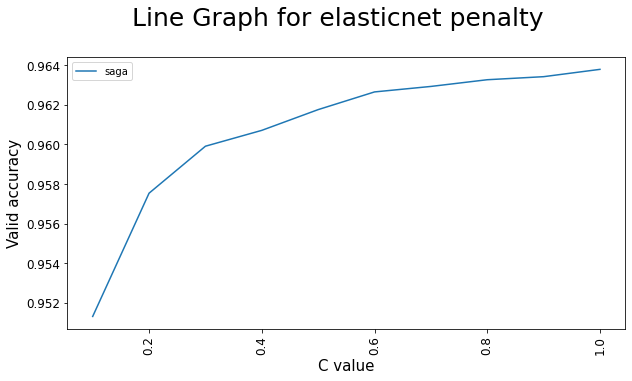

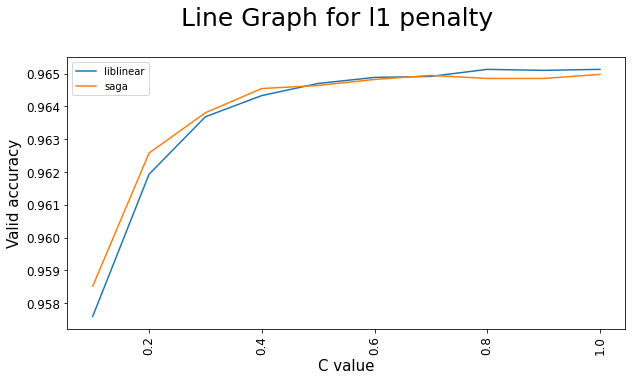

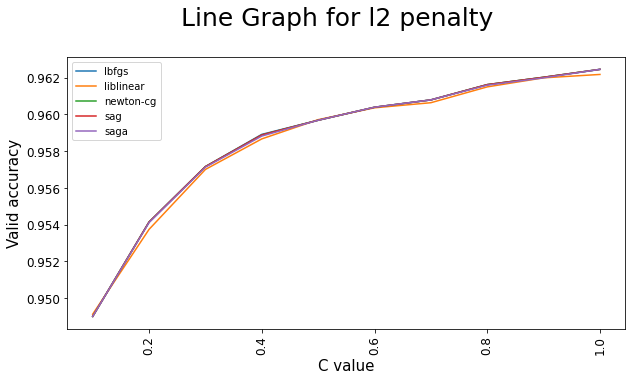

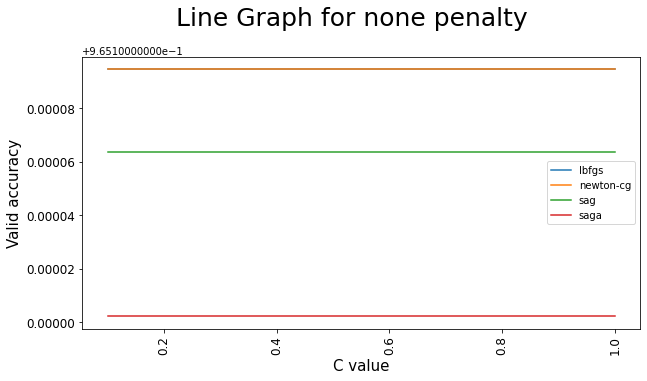

In [68]:
for penalty in grouped_logistic_classification_results_df.penalty.unique():
    plot_line_for_penalty(grouped_logistic_classification_results_df, penalty)

### Train accuracy for every penalty type

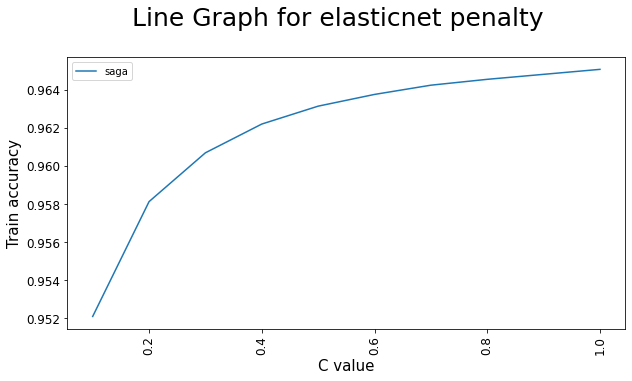

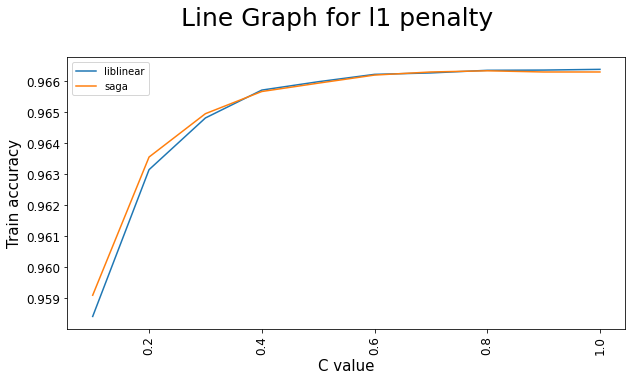

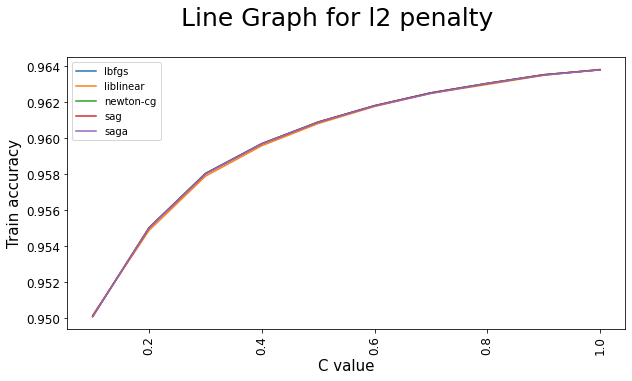

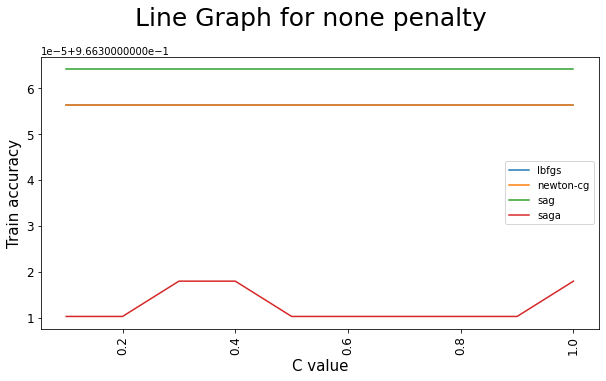

In [69]:
for penalty in grouped_logistic_classification_results_df.penalty.unique():
    plot_line_for_penalty(grouped_logistic_classification_results_df, penalty, acc='train_accuracy')

### Valid precision score for every penalty type

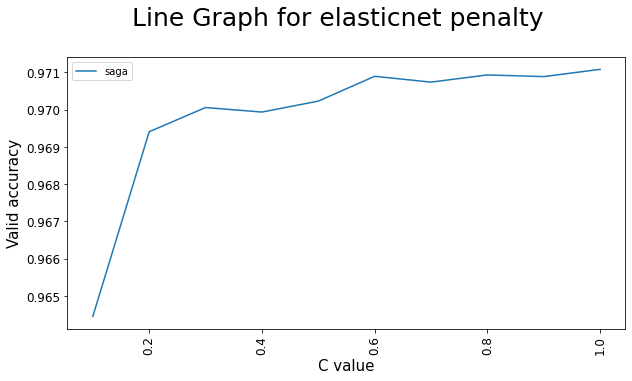

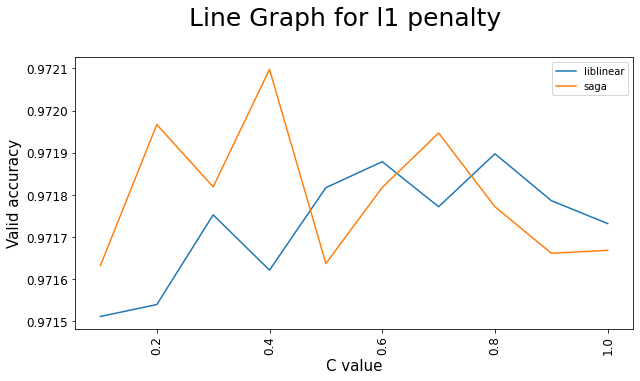

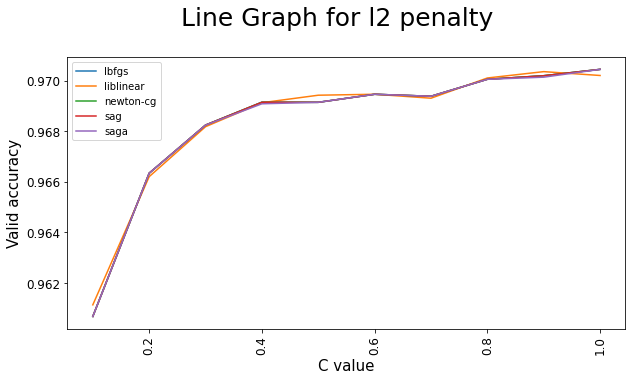

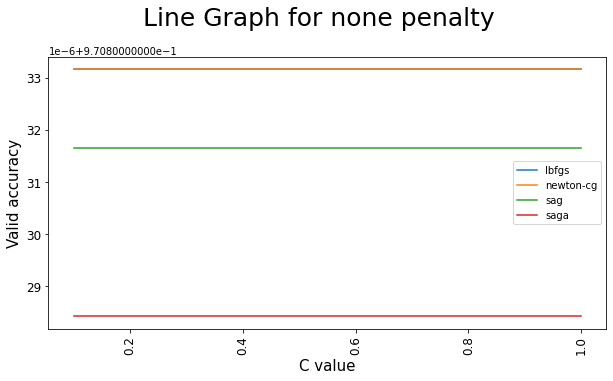

In [70]:
for penalty in grouped_logistic_classification_results_df.penalty.unique():
    plot_line_for_penalty(grouped_logistic_classification_results_df, penalty, acc='valid_precision')

### Valid recall score for every penalty type

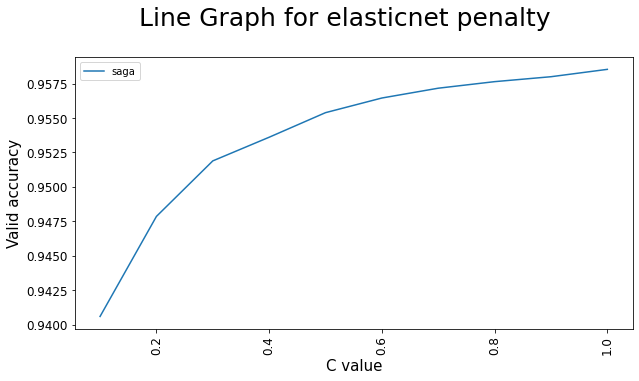

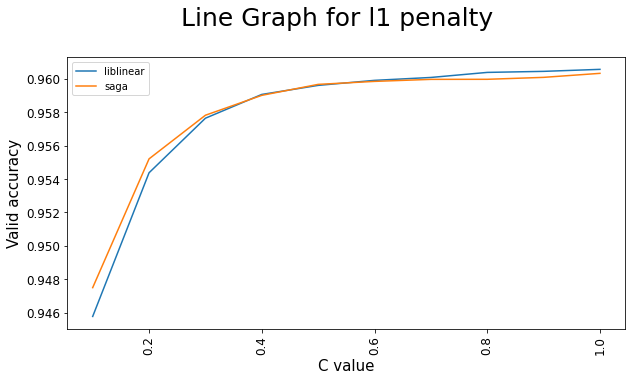

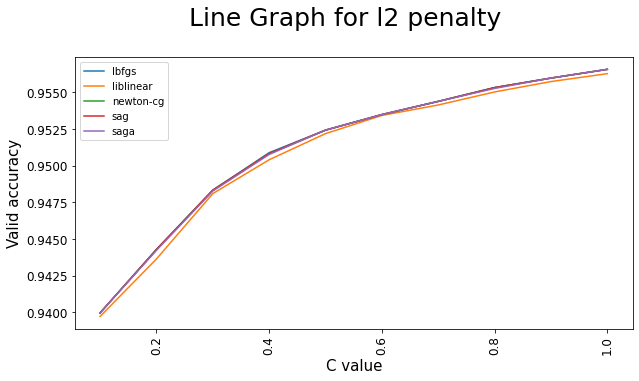

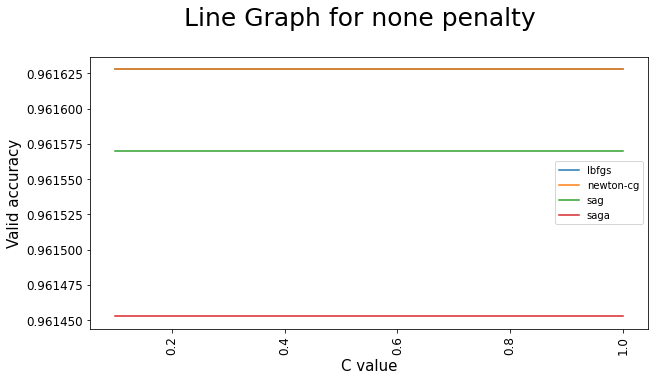

In [71]:
for penalty in grouped_logistic_classification_results_df.penalty.unique():
    plot_line_for_penalty(grouped_logistic_classification_results_df, penalty, acc='valid_recall')

### Valid f1 score for every penalty type

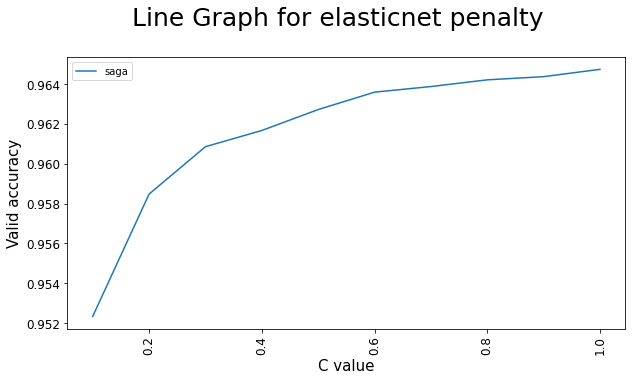

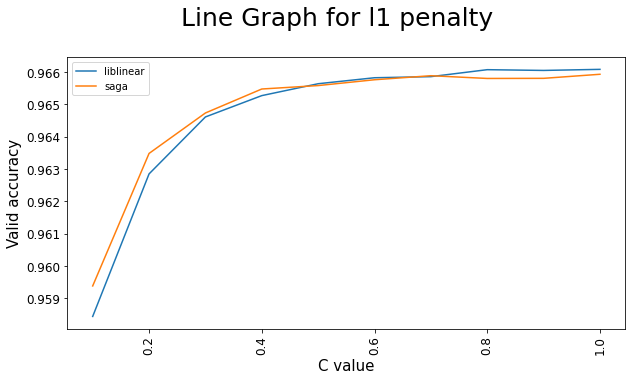

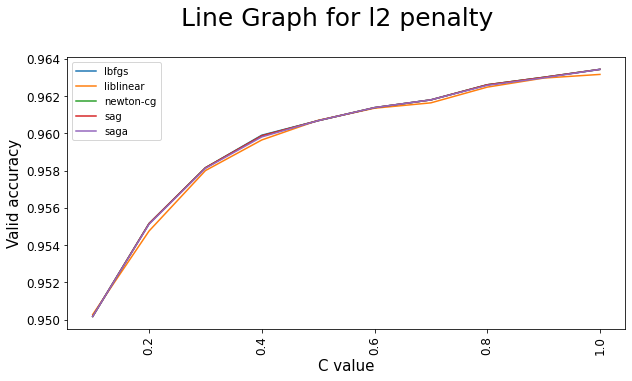

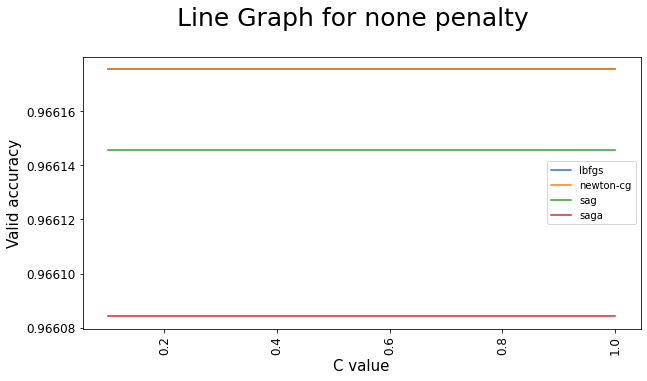

In [72]:
for penalty in grouped_logistic_classification_results_df.penalty.unique():
    plot_line_for_penalty(grouped_logistic_classification_results_df, penalty, acc='valid_f1_score')

### Valid auroc score for every penalty type

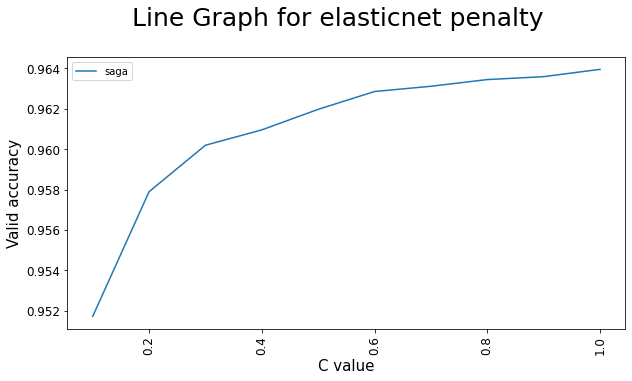

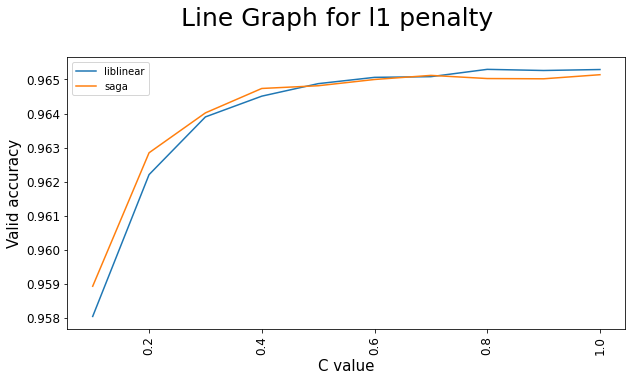

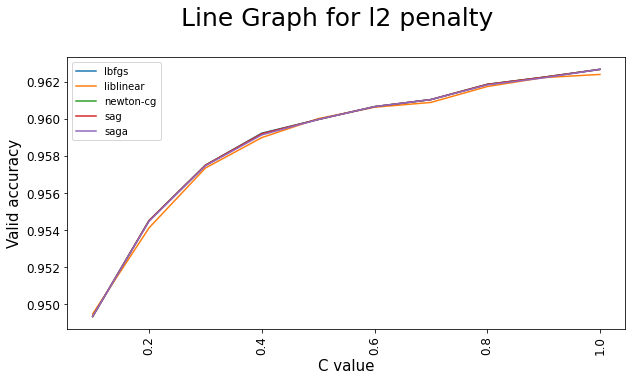

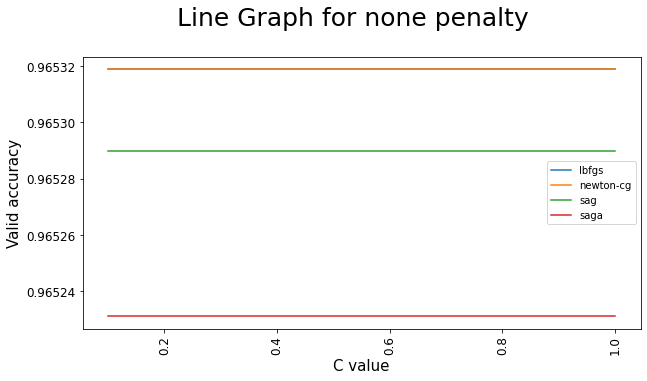

In [73]:
for penalty in grouped_logistic_classification_results_df.penalty.unique():
    plot_line_for_penalty(grouped_logistic_classification_results_df, penalty, acc='valid_auroc')

----------

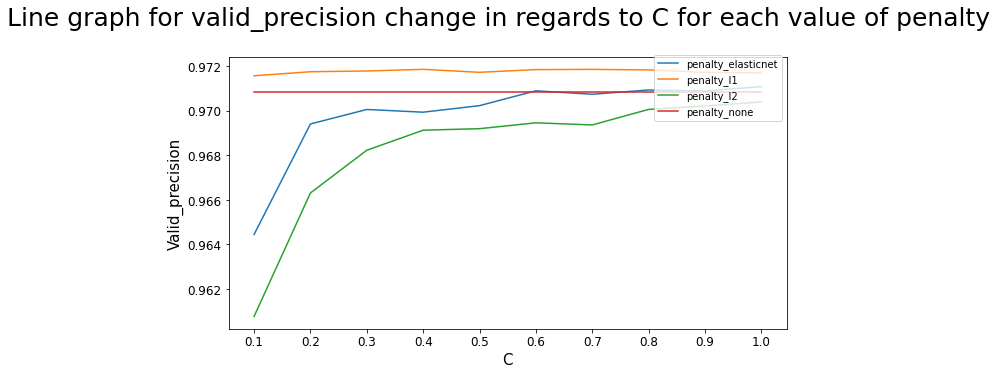

In [25]:
plot_line(grouped_logistic_classification_results_df, x_column='C', groupby_column = 'penalty', acc='valid_precision')

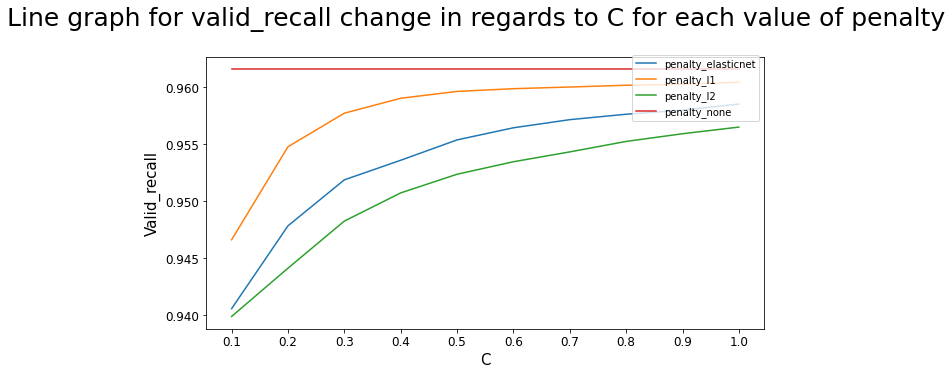

In [28]:
plot_line(grouped_logistic_classification_results_df, x_column='C', groupby_column = 'penalty', acc='valid_recall')

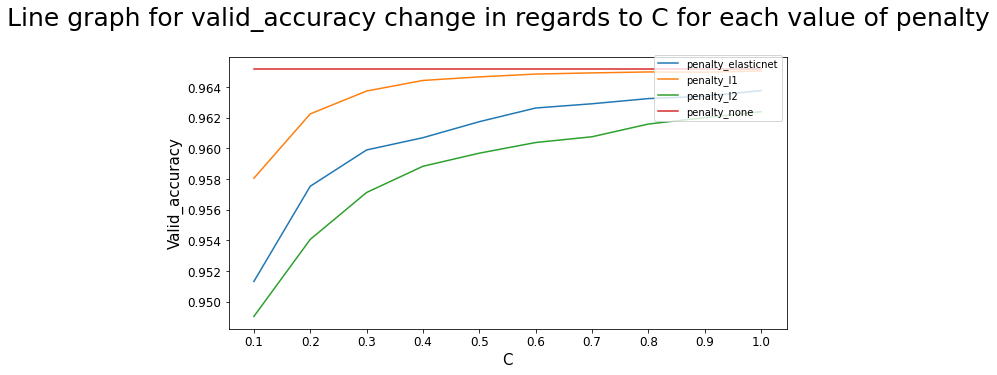

In [29]:
plot_line(grouped_logistic_classification_results_df, x_column='C', groupby_column = 'penalty', acc='valid_accuracy')

--------------

As it was made clear in the EDA in the other notebook, data is distributed equally, therefore all of the above metrics are good model evaluators. However, when we are dealing with edible and poisonous mushrooms it is important to not mistake a poisonous for an edible mushroom (the opposite is not that important), therefore precision is the most important metric.

In [30]:
grouped_logistic_classification_results_df[grouped_logistic_classification_results_df['valid_precision'] == grouped_logistic_classification_results_df['valid_precision'].max()]

,penalty,C,solver,train_accuracy,valid_accuracy,valid_precision,valid_recall,valid_f1_score,valid_auroc
17,l1,0.4,saga,0.965672,0.964548,0.972098,0.959007,0.965479,0.964736


Now we need to save the best model and test it on the test data.

In [31]:
best_model = LogisticRegression(penalty='l1',
                                C=0.4,
                                solver='saga')

Preprocess the data

In [32]:
# Avoiding data leakage for input values
enc = preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=100)
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)

# as output varaibles are stratified on, there is not any unknowon variable, therefore no possibility of data leakage
encoder_dict = {'edible': 1,
                'poisonous': 0}
# transform the output into the right format
y_train_enc = y_train.replace(encoder_dict).values.flatten()
y_test_enc = y_test.replace(encoder_dict).values.flatten()

In [33]:
best_pipe = make_pipeline(preprocessing.StandardScaler(), 
                          best_model)

Train the model

In [34]:
best_pipe = best_pipe.fit(X_train_enc, y_train_enc) 

d:\uni\masters\diss\diss\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Obtain metric scores

In [35]:
test_predictions = best_pipe.predict(X_test_enc)
test_prec_score = precision_score(y_test_enc, test_predictions)
test_rec_score = recall_score(y_test_enc, test_predictions)
test_f1_score = f1_score(y_test_enc, test_predictions)
fpr, tpr, threshold = roc_curve(y_test_enc, test_predictions)
test_auroc = auc(fpr, tpr)
test_accuracy = best_pipe.score(X_test_enc, y_test_enc)
train_accuracy = best_pipe.score(X_train_enc, y_train_enc)

-----

### Results on test set

In [36]:
print(f"The predicion score on the test set for the best model is {test_prec_score.round(3)} \n")

The predicion score on the test set for the best model is 0.972 



In [37]:
print(f"The recall score on the test set for the best model is {test_rec_score.round(3)} \n")

The recall score on the test set for the best model is 0.963 



In [38]:
print(f"The f1-score on the test set for the best model is {test_f1_score.round(3)} \n")

The f1-score on the test set for the best model is 0.968 



In [39]:
print(f"The auroc score on the test set for the best model is {test_auroc.round(3)} \n")

The auroc score on the test set for the best model is 0.967 



In [40]:
print(f"The accuracy on the test set for the best model is {test_accuracy.round(3)} \n")

The accuracy on the test set for the best model is 0.967 



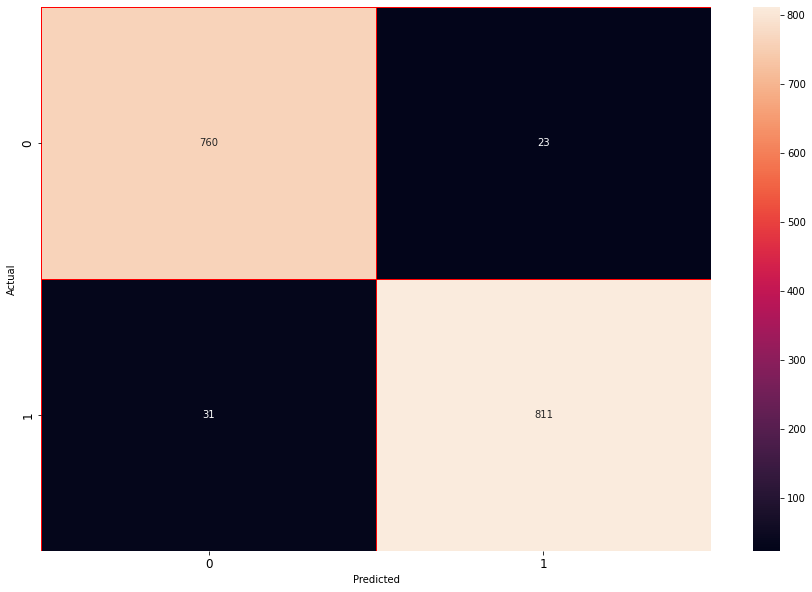

In [43]:
plot_conf_matrix(y_test_enc, test_predictions)

Save the model on disc

In [44]:
pickle.dump(best_pipe, open(models_dir+model_name, 'wb'))

Load the model from disk

In [45]:
loaded_best_pipe = pickle.load(open(models_dir+model_name, 'rb'))